In [19]:
import os
import logging
from pathlib import Path

from dotenv import dotenv_values
import wandb
import numpy as np
import torch
import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from exrep.registry import load_data, save_data, load_model, load_tensor, get_artifact

if 'notebooks' in os.getcwd():
    os.chdir("../")

local_config = dotenv_values(".env")
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

random_state = 42

embedding_artifact_name = "imagenet-1k-first-20-take-2000_target-embeddings_mocov3-resnet50"
image_artifact_name = "imagenet-1k-first-20-take-2000_images"
output_phase_name = "surrogate"

run = wandb.init(
    project=local_config["WANDB_PROJECT"],
    config={
        "job_type": "train_representation",
    },
    # reinit=True,
    # save_code=True,
)

device = "cuda:7"

In [20]:
train_configs = {
    "surrogate": dict(
        output_dim=16,
    ),
    "loss": dict(
        gamma1=1.0,
        gamma2=1.0,
        temp_student=0.08,
        temp_teacher=1,
    ),
    "optimizer": dict(
        lr=1e-3,
        weight_decay=1e-4,
    )
}
run.config.update(train_configs)

In [23]:
wandb.finish(1)

classify_train_acc,▁▂▃▃▄▄▄▅▅▅▆▆▆▇███████▇▇▇▇▇▇▇█▇▇▇▇███████
classify_val_acc,▁▂▃▃▂▃▄▅▄▄▅▅▅▆▆▆▆▆▆▇█▇▇▇█████▇▆▆▇▇▆▆▆▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇████
grad_estimator,██▆▆▅▅▅▄▄▅▃▄▄▄▃▄▂▂▃▂▃▃▃▃▃▂▃▃▂▂▃▂▃▃▃▂▁▁▂▁
loss,█▇▆▆▆▅▅▄▅▄▄▄▄▄▃▃▃▃▂▃▃▃▂▂▂▂▂▁▂▁▂▁▁▁▂▂▁▁▂▂
loss_reg,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇█████
val_grad_estimator,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classify_train_acc,0.73389
classify_val_acc,0.72


In [21]:
encoding = load_tensor(
    base_name="imagenet",
    phase="local-encoding",
    identifier="agglomerative",
    file_name="local-encoding_80.pt",
    map_location=device,
    wandb_run=run,
)
embeddings = load_tensor(
    "embeddings.pt",
    artifact_name=embedding_artifact_name,
    map_location=device,
    wandb_run=run,
)
images_path = get_artifact(
    image_artifact_name,
    wandb_run=run,
).download()
images_dataset = datasets.load_from_disk(images_path)
labels_dataset = images_dataset.remove_columns(["image"])

if isinstance(embeddings, list):
    embeddings = torch.cat(embeddings, dim=0)
embeddings_dataset = datasets.Dataset.from_dict({"targets": embeddings})
encoding_dataset = datasets.Dataset.from_dict({"inputs": encoding})

xy_dataset = datasets.concatenate_datasets(
    [encoding_dataset, embeddings_dataset, labels_dataset],
    axis=1
).with_format("torch").train_test_split(0.1, shuffle=False, seed=random_state)

logger.info("Encoding shape: %s", encoding.shape)
logger.info("Embeddings shape: %s", embeddings.shape)
logger.info("Image dataset: %s", images_dataset)
logger.info("XY dataset: %s", xy_dataset)

/blue/thai/hoangx/projects/explain-representation/exrep/registry.py:192: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file_path, map_location=map_locati

In [22]:
%load_ext autoreload
%autoreload 2

from exrep.train import train_local_representation

model, logs = train_local_representation(
    alpha=0,
    model_config=run.config.surrogate,
    loss_config=run.config.loss,
    optimizer_config=run.config.optimizer,
    train_dataset=xy_dataset["train"],
    val_dataset=xy_dataset["test"],
    keys=embeddings,
    groups=None,
    wandb_run=run,
    num_epochs=40,
    batch_size=512,
    log_every_n_steps=10,
    device=device,   
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:exrep.train:Epoch  2, Step   10, Loss: 0.85572
INFO:exrep.train:Epoch  4, Step   20, Loss: 0.72043
INFO:exrep.train:Epoch  7, Step   30, Loss: 0.71566
INFO:exrep.train:Epoch  9, Step   40, Loss: 0.63118
INFO:exrep.train:Epoch 12, Step   50, Loss: 0.64612
INFO:exrep.train:Epoch 14, Step   60, Loss: 0.56890
INFO:exrep.train:Epoch 17, Step   70, Loss: 0.60004
INFO:exrep.train:Epoch 19, Step   80, Loss: 0.52592
INFO:exrep.train:Epoch 22, Step   90, Loss: 0.57056
INFO:exrep.train:Epoch 24, Step  100, Loss: 0.49576
INFO:exrep.train:Epoch 27, Step  110, Loss: 0.54941
INFO:exrep.train:Epoch 29, Step  120, Loss: 0.47272
INFO:exrep.train:Epoch 32, Step  130, Loss: 0.53241
INFO:exrep.train:Epoch 34, Step  140, Loss: 0.45501
INFO:exrep.train:Epoch 37, Step  150, Loss: 0.51822
INFO:exrep.train:Epoch 39, Step  160, Loss: 0.44071
INFO:exrep.train:|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 7              

In [11]:
logs['val']

[{'epoch': 0,
  'step': 4,
  'val_grad_estimator': 6.773936748504639,
  'val_loss': 6.773936748504639,
  'classify_train_acc': 0.6655555555555556,
  'classify_val_acc': 0.625},
 {'epoch': 1,
  'step': 8,
  'val_grad_estimator': 6.505286693572998,
  'val_loss': 6.505286693572998,
  'classify_train_acc': 0.6744444444444444,
  'classify_val_acc': 0.635},
 {'epoch': 2,
  'step': 12,
  'val_grad_estimator': 6.305582046508789,
  'val_loss': 6.305582046508789,
  'classify_train_acc': 0.6838888888888889,
  'classify_val_acc': 0.65},
 {'epoch': 3,
  'step': 16,
  'val_grad_estimator': 6.1213250160217285,
  'val_loss': 6.1213250160217285,
  'classify_train_acc': 0.6933333333333334,
  'classify_val_acc': 0.645},
 {'epoch': 4,
  'step': 20,
  'val_grad_estimator': 5.950815677642822,
  'val_loss': 5.950815677642822,
  'classify_train_acc': 0.6988888888888889,
  'classify_val_acc': 0.665},
 {'epoch': 5,
  'step': 24,
  'val_grad_estimator': 5.79874324798584,
  'val_loss': 5.79874324798584,
  'classi

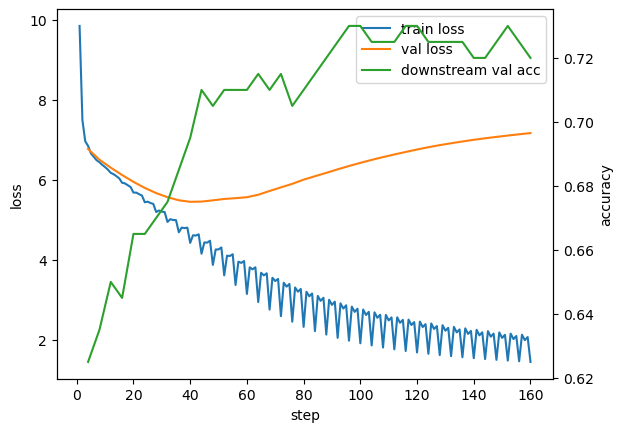

In [12]:
fig, ax = plt.subplots()

twin1 = ax.twinx()

p1, = ax.plot([log["step"] for log in logs["train"]], [log["loss"] for log in logs["train"]], 'C0', label="train loss")
p2, = ax.plot([log["step"] for log in logs["val"]], [log["val_loss"] for log in logs["val"]], 'C1', label="val loss")
p3, = twin1.plot([log["step"] for log in logs["val"]], [log["classify_val_acc"] for log in logs["val"]], 'C2', label="downstream val acc")
# p4, = ax.plot([log["step"] for log in logs["train"]], [log["grad_estimator"] for log in logs["train"]], 'C3', label="train total loss")

ax.set_ylabel("loss")
ax.set_xlabel("step")
# ax.set_ylim([0, 1])
twin1.set_ylabel("accuracy")
ax.legend(handles=[p1, p2, p3])

In [14]:
samples_batch = xy_dataset["train"][:100]
keys_batch = embeddings[:100]

In [16]:
torch.round(torch.softmax((samples_batch["targets"] @ samples_batch["targets"].T) / train_configs['loss']['temp_teacher'], dim=-1), decimals=3)

tensor([[0.7930, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0080, 0.0300, 0.0090,  ..., 0.0120, 0.0100, 0.0090],
        [0.0000, 0.0000, 0.4970,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0040, 0.0040, 0.0050,  ..., 0.3580, 0.0060, 0.0050],
        [0.0000, 0.0000, 0.0010,  ..., 0.0000, 0.6040, 0.0010],
        [0.0060, 0.0040, 0.0060,  ..., 0.0080, 0.0120, 0.1490]])

In [17]:
q, k = model.encode(query=samples_batch["inputs"].to(device), key=samples_batch["targets"].to(device), normalize=True)
torch.softmax(q @ k.T / model.temperature, dim=1)

tensor([[0.0442, 0.0060, 0.0062,  ..., 0.0065, 0.0082, 0.0062],
        [0.0090, 0.0079, 0.0076,  ..., 0.0113, 0.0104, 0.0094],
        [0.0091, 0.0044, 0.0098,  ..., 0.0054, 0.0102, 0.0045],
        ...,
        [0.0086, 0.0070, 0.0062,  ..., 0.0156, 0.0168, 0.0087],
        [0.0081, 0.0071, 0.0078,  ..., 0.0088, 0.0456, 0.0076],
        [0.0079, 0.0071, 0.0096,  ..., 0.0105, 0.0121, 0.0102]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [9]:
image_dataset = load_data(
    base_name="imagenet-1k-first-20-take-2000",
    phase="images",
    wandb_run=run,
)

wandb: Downloading large artifact imagenet-1k-first-20-take-2000_images:latest, 230.91MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8


In [80]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

downstream_labels = image_dataset["label"]
pred_embeds = model.encode(query=encoding.float().to(device), normalize=True).detach().cpu().numpy()
target_embeds = embeddings.cpu().numpy()

Y_train, Y_test, P_train, P_test, K_train, K_test = train_test_split(downstream_labels, pred_embeds, target_embeds, random_state=random_state, test_size=0.1, stratify=downstream_labels)
print(len(Y_train), len(Y_test), len(P_train), len(P_test), len(K_train), len(K_test))

classifier = SVC(kernel="linear").fit(K_train, Y_train)
orig_preds = classifier.predict(K_test)
# surrogate_preds = classifier.predict(P_test)

1800 200 1800 200 1800 200


In [57]:
model.query_encoder.weight.shape

torch.Size([16, 20])

In [81]:
surrogate_classifier = SVC(kernel="linear").fit(P_train, Y_train)
surrogate_preds = surrogate_classifier.predict(P_test)

surrogate_acc = (surrogate_preds == Y_test).mean()

print(f"Surrogate accuracy: {surrogate_acc}")
print("Original accuracy:", (orig_preds == Y_test).mean(), "Surrogate accuracy:", (surrogate_preds == Y_test).mean())

Surrogate accuracy: 0.695
Original accuracy: 0.735 Surrogate accuracy: 0.695


In [82]:
matcher_classifier = SVC(kernel="linear").fit(P_train, classifier.predict(K_train).reshape(-1, 1))
surrogate_preds = surrogate_classifier.predict(P_test)

surrogate_acc = (surrogate_preds == classifier.predict(K_test)).mean()

print(f"Surrogate matching accuracy: {surrogate_acc}")

/home/hoangx/persist/envs/exrep/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Surrogate matching accuracy: 0.615


In [239]:
wandb.finish()

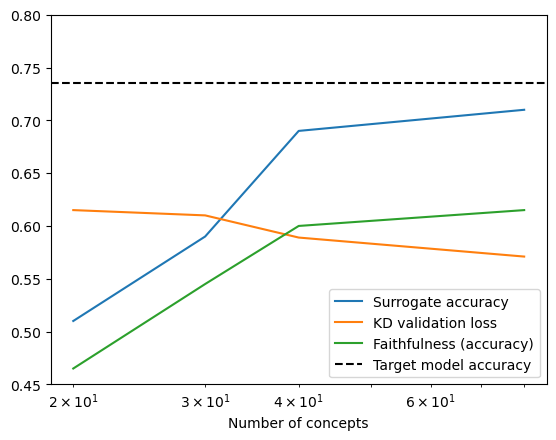

In [98]:
import matplotlib.pyplot as plt

x = [20, 30, 40, 80]
y1 = [0.51, 0.59, 0.69, 0.71]
y2 = [0.615, 0.61, 0.589, 0.571]
y3 = [0.465, 0.545, 0.6, 0.615]

fig, ax = plt.subplots()
ax.plot(x, y1, label="Surrogate accuracy")
ax.plot(x, y2, label="KD validation loss")
ax.plot(x, y3, label="Faithfulness (accuracy)")
ax.set_xlabel("Number of concepts")
plt.axhline(y=0.735, linestyle="--", color="black", label="Target model accuracy")
ax.set_ybound(0.45, 0.8)
# set x log scale
ax.set_xscale('log')
ax.legend()

plt.show()